In [157]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt

In [158]:
# import tensorflow datasets
data = tf.data.TFRecordDataset('../../data/external/EuroSAT/eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001')

labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [159]:
# inspect the first record
for raw_record in data.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "SeaLake_2401.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\027\000\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\002\n\377\304\000(\020\

In [160]:
# see length of dataset
print(len(list(data)))

27000


In [161]:
# print size of each of the 10 classes
for label in labels:
    count = 0
    for raw_record in data:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        if example.features.feature['label'].int64_list.value[0] == labels.index(label):
            count += 1
    print(label, count)

AnnualCrop 3000
Forest 3000
HerbaceousVegetation 3000
Highway 2500
Industrial 2500
Pasture 2000
PermanentCrop 2500
Residential 3000
River 2500
SeaLake 3000


SeaLake
(64, 64, 3)


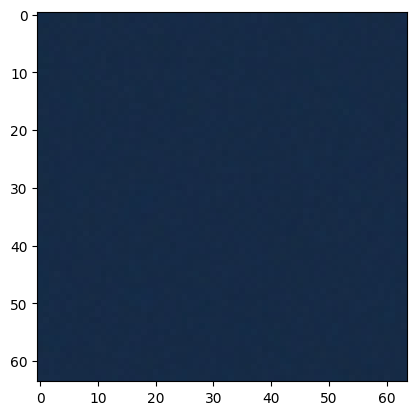

PermanentCrop
(64, 64, 3)


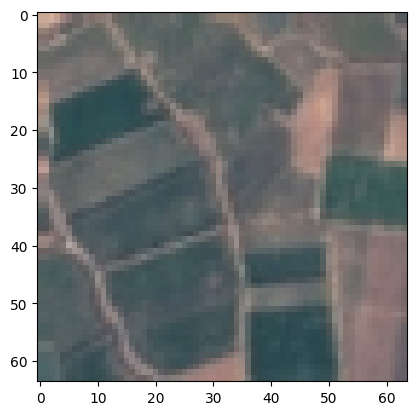

SeaLake
(64, 64, 3)


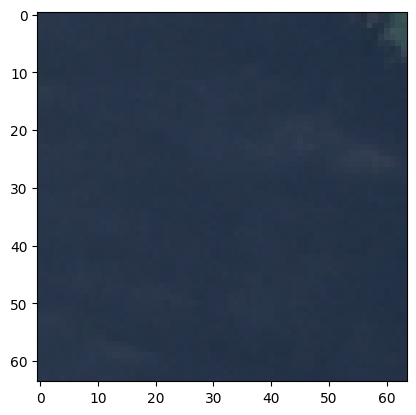

Industrial
(64, 64, 3)


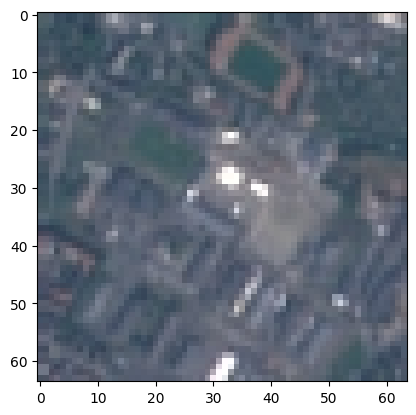

Pasture
(64, 64, 3)


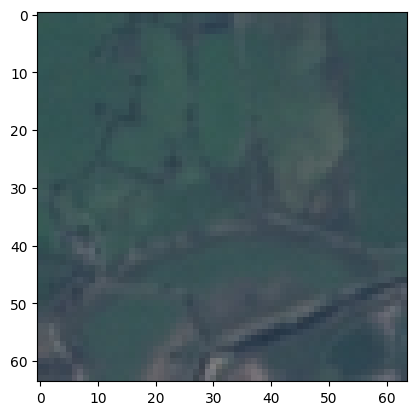

In [147]:
# parse single image from tfrecord
def parse_image(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed_features['image'])

    label = tf.cast(parsed_features['label'], tf.int32)
    return image, label

def resize_image(image, label):
    image = tf.image.resize(image, [64, 64])
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

def split_into_batches(dataset, batch_size):
    return dataset.cache().shuffle(27000).batch(batch_size)

def split_into_train_test_validation(dataset, batch_size):
    train_size = int(0.5 * 27000)
    validation_set = int(0.3 * 27000)
    test_size = int(0.2 * 27000)
    train_dataset = dataset.take(train_size).cache().shuffle(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_set).cache().shuffle(validation_set)
    test_dataset = dataset.skip(train_size).skip(validation_set).take(test_size).cache().shuffle(test_size)
    return train_dataset, validation_dataset, test_dataset


def sample_images(dataset, batch_size, num_batches=500):
    return dataset.take(num_batches*batch_size).cache().batch(batch_size)

# parse first image from data
parsed_image_dataset = data.map(parse_image)
parsed_image_dataset = parsed_image_dataset.map(resize_image)

for image, label in parsed_image_dataset.take(5):
  image_raw = image.numpy()
  print(labels[label.numpy()])
  print(image_raw.shape)
  plt.imshow(image_raw.astype('uint8'))
  plt.show()
  plt.close()
  
parsed_image_dataset = parsed_image_dataset.map(normalize)
# split into train and test
train_dataset, validation_dataset, test_dataset = split_into_train_test_validation(parsed_image_dataset, 32)
train_dataset = sample_images(train_dataset, 50, num_batches=1000)
validation_dataset = sample_images(validation_dataset, 50)
test_dataset = sample_images(test_dataset, 50)

  

In [151]:
# augment data
data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(64, 64, 3)),
#   tf.keras.layers.RandomRotation(1),
  tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.5, input_shape=(64, 64, 3)),
])

# build CNN model
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# compile model
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

# train model
history = model.fit(train_dataset, epochs=50, batch_size=50, validation_data=test_dataset, callbacks=[early_stopping])
# evaluate model
model.evaluate(test_dataset, batch_size=50)




Epoch 1/50
270/270 [==============================] - 26s 89ms/step - loss: 1.7892 - accuracy: 0.3047 - val_loss: 1.4210 - val_accuracy: 0.4561
Epoch 2/50
270/270 [==============================] - 25s 92ms/step - loss: 1.4168 - accuracy: 0.4640 - val_loss: 1.1730 - val_accuracy: 0.5865
Epoch 3/50
270/270 [==============================] - 28s 104ms/step - loss: 1.2115 - accuracy: 0.5679 - val_loss: 0.9927 - val_accuracy: 0.6381
Epoch 4/50
270/270 [==============================] - 39s 144ms/step - loss: 1.1191 - accuracy: 0.6076 - val_loss: 0.9557 - val_accuracy: 0.6635
Epoch 5/50
270/270 [==============================] - 45s 165ms/step - loss: 1.0477 - accuracy: 0.6299 - val_loss: 0.8309 - val_accuracy: 0.7043
Epoch 6/50
270/270 [==============================] - 43s 157ms/step - loss: 0.9738 - accuracy: 0.6574 - val_loss: 0.8503 - val_accuracy: 0.6902
Epoch 7/50
270/270 [==============================] - 42s 156ms/step - loss: 0.9328 - accuracy: 0.6682 - val_loss: 0.8163 - val_accu

[0.5904898047447205, 0.7955555319786072]

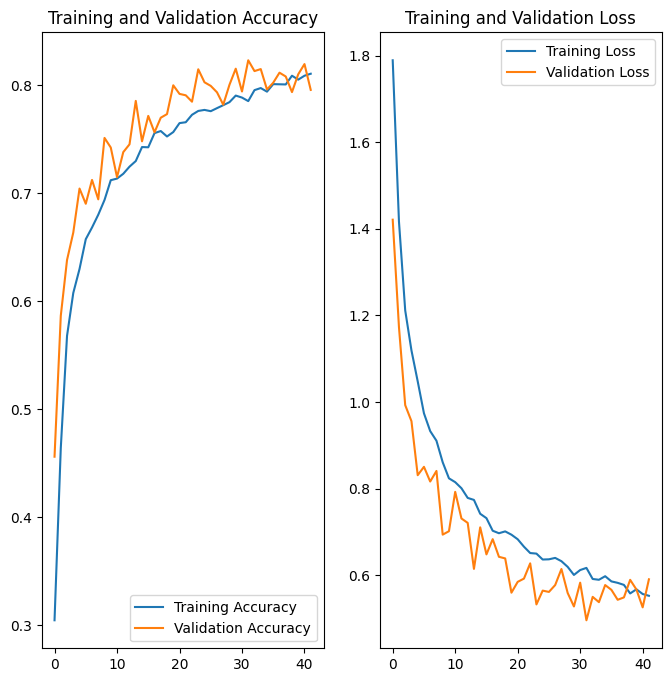

In [152]:
# plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


2/2 [==============================] - 0s 8ms/step


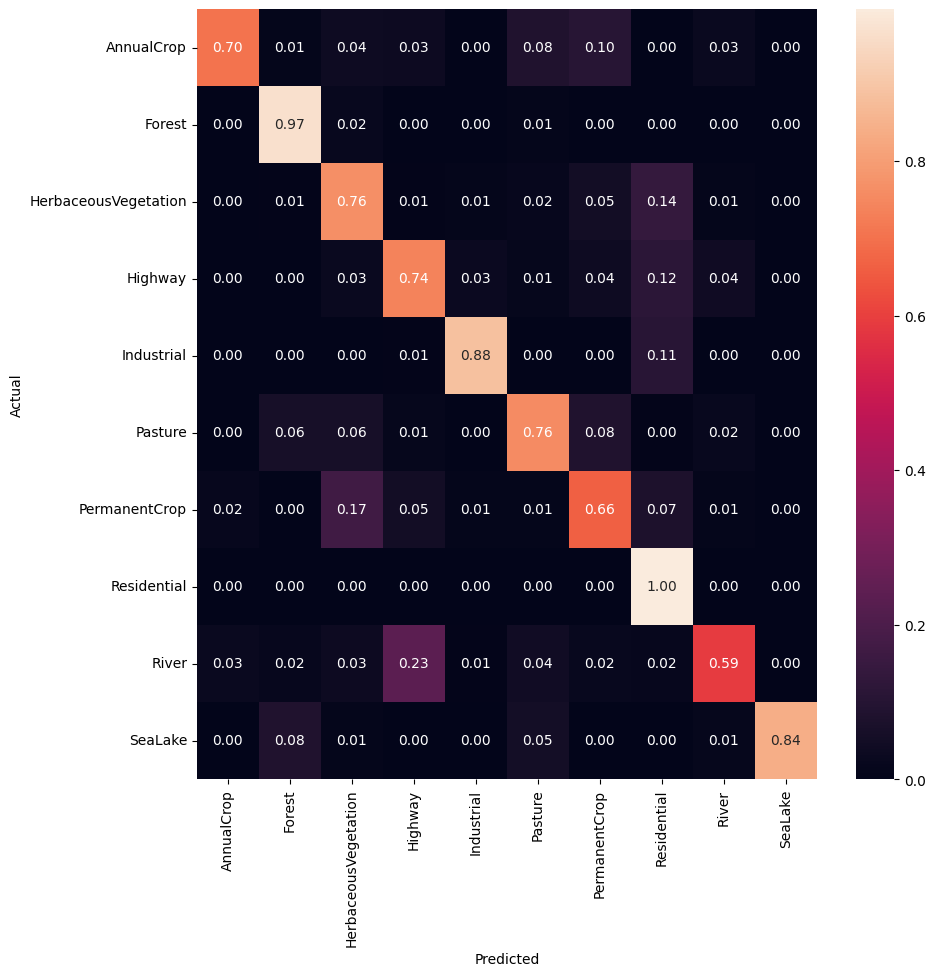

In [153]:
# evaluate in a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = []
y_pred = []
images = []
for image, label in test_dataset:
    y_true.append(label)
    y_pred.append(model.predict(image))
    images.append(image)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
image_list = np.concatenate(images)

y_pred_max = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_max)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [154]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  # plt.imshow(img[...,0], cmap=plt.cm.binary)
  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)
# change xlabel size
  plt.rcParams['xtick.labelsize'] = 10

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')



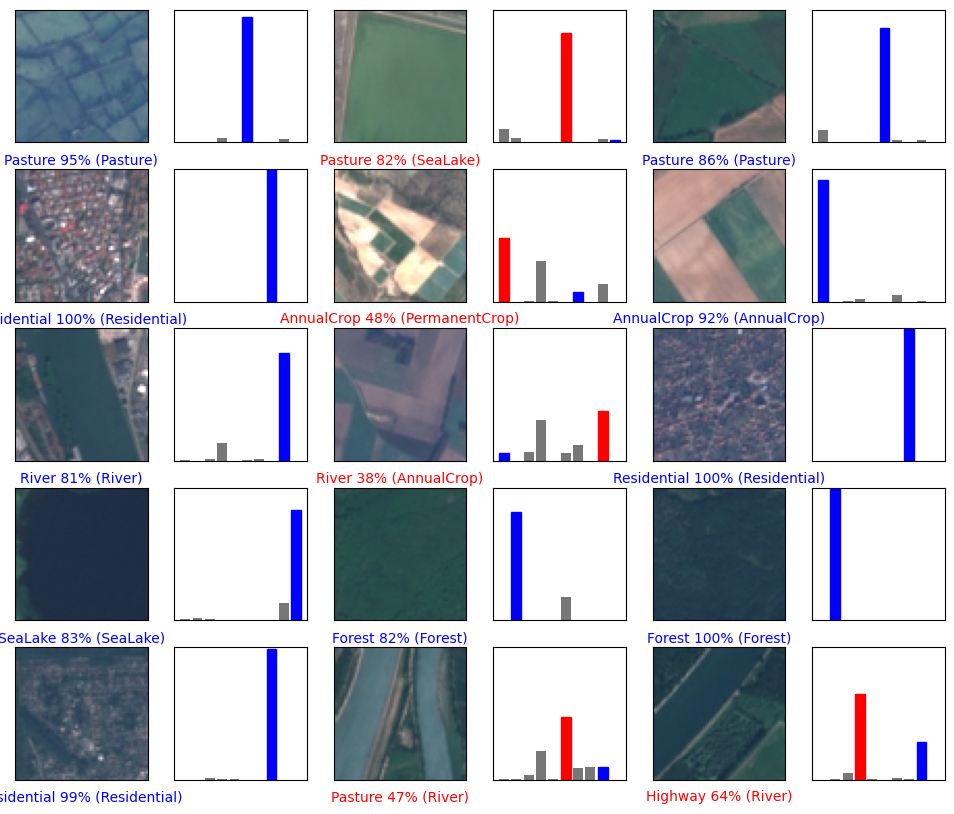

In [155]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred, y_true, image_list)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, y_pred, y_true)
plt.savefig('../../reports/figures/EuroSAT/satellite_items.png')